# Improving Construction Task Completion

**Applicant:** Melissa Catherine Rajamanuvel  
**Program:** Data Science, University of Wisconsin–Madison  

# About the Dataset Used
**Dataset Title:** Construction and Project Management Example Data

**Source:** Kaggle - Donated by Jason Rymer, BIM Manager (Ireland)

# Project Introduction

## What is this data?

Imagine a big construction site where people are building things like houses or schools. Every day, team members fill out **forms** to say what happened — like if they checked the safety, cleaned the area, or did an inspection.

If something looks wrong or needs to be fixed, they create a **task** — like "fix this crack in the wall" or "clean up the spilled materials."

This dataset has two parts:
-`Forms`: What was filled out on-site (checklists and reports)
-`Tasks`: What was done or still needs to be done because of those reports from the forms

---

## What is this project about?

The goal of this project is to help construction project managers identify where and why tasks are getting delayed, so they can take action to prevent risks and improve efficiency.

### Key Questions This Project Answers:

1. **Where are the most overdue tasks happening?**  

2. **Which teams are involved in those tasks?**  

3. **When are things getting delayed the most?**  

4. **What actions can we take to improve?**  

By the end of this analysis, I aim to provide actionable insights that help construction teams **save time**, **avoid delays**, and **build safer structures**.


# Skill Demonstration: ETL (Extract, Transform, Load)

This part of my project shows how I can **support ETL processes**

In [48]:
#imports for data cleaning
import pandas as pd
import os           
from pathlib import Path
#imports for data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
#imports for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

We use the `pathlib` library in Python to get the path of our data files in a way that works on **any computer**. This makes our code **reproducible** and easy to share with our team.

In [5]:
path= Path().resolve()
forms_path = path / "Construction_Data_PM_Forms_All_Projects.csv"
tasks_path = path / "Construction_Data_PM_Tasks_All_Projects.csv"

In [6]:
# Extract
forms= pd.read_csv(forms_path)
tasks= pd.read_csv(tasks_path)

In [7]:
# Transform 
#Always remove white space and put the column names to lower case this is for keep things clear and uniform.
forms.columns=[col.strip().lower().replace(" ", "_") for col in forms.columns]
tasks.columns=[col.strip().lower().replace(" ", "_") for col in tasks.columns]

In [8]:
#before cleaning note down the col and rows of the dataset. We need this to check after cleaning how much data we have lost
print(forms.shape)
print(tasks.shape)

(10254, 17)
(12424, 19)


In [9]:
#drop the NAs
forms_drop=forms.dropna()
tasks_drop=tasks.dropna()

In [10]:
#check the shape of the data again
print(forms_drop.shape)
print(tasks_drop.shape)

(1793, 17)
(69, 19)


By removing the NA we have a huge data loss, it is deleting all the rows with one cell has an NA. This cell might not be useful. At this point we need to find our columns that are important to us and how much of NAs are there in each column.

In [11]:
print("Missing values in FORMS:")
print(forms.isnull().sum())

print("Missing values in TASKS:")
print(tasks.isnull().sum())


Missing values in FORMS:
ref                       0
status                    0
location                  0
name                      0
created                   0
type                      0
status_changed            0
open_actions              0
total_actions             0
association            8156
overdue                   0
images                    0
comments                  0
documents               804
project                   0
report_forms_status       2
report_forms_group        4
dtype: int64
Missing values in TASKS:
ref                   0
status                0
location              0
description           0
created               0
target             9856
type                  0
to_package         1042
status_changed        0
association        2941
overdue               0
images              152
comments            522
documents           644
priority          10058
cause              2741
project               0
report_status         0
task_group           50
dtype

Here in the **Forms data set**, I see that assosciation and documents seems to have a lot of NAs and they are not an important info for our analysis so I decide to remove the association and documents column.
Final Column Decisions for TASKS

After reviewing all columns, I kept most of the data to preserve insights. I only removed:
- `target`: Over 80% missing
- `to_package` and `association`: Not relevant to this analysis

I chose to **keep** `report_status` based on its potential usefulness in evaluating task progress and workflow reporting.

To handle missing values:
- I filled fields like `priority`, `cause`, and `task_group` with placeholders
- I only dropped rows where essential information (`type`, `description`, `task_group`) was missing

This approach keeps the dataset rich and ready for deeper analysis without unnecessary data loss.

In [12]:
# Drop unimportant columns 
forms = forms.drop(columns=["association", "documents"], errors="ignore")

# Fill missing values in useful TASKS columns
tasks["priority"] = tasks["priority"].fillna("Unknown")
tasks["cause"] = tasks["cause"].fillna("Unspecified")
tasks["task_group"] = tasks["task_group"].fillna("Other")
tasks["comments"] = tasks["comments"].fillna("No comment")
tasks["documents"] = tasks["documents"].fillna("None")
tasks["images"] = tasks["images"].fillna("None")

# Drop rows with missing values in key columns only
forms_clean = forms.dropna(subset=["type", "created", "report_forms_group"])
tasks_clean = tasks.dropna(subset=["type", "description", "task_group"])

# Check shape after cleaning
print("FORMS shape:", forms_clean.shape)
print("TASKS shape:", tasks_clean.shape)

FORMS shape: (10250, 15)
TASKS shape: (12424, 19)


In [13]:
#Load
# Save clean versions to share with the team 
forms_clean.to_csv("clean_forms.csv", index=False)
tasks_clean.to_csv("clean_tasks.csv", index=False)

# Conduct statistical analysis

After the ELT it is always good to do the data visualization to see what is happening


In [21]:
#This is just a design style to make graphs look neat
sns.set(style="whitegrid")
task=tasks_clean
form=forms_clean

# Where Are Most Overdue Tasks Happening?

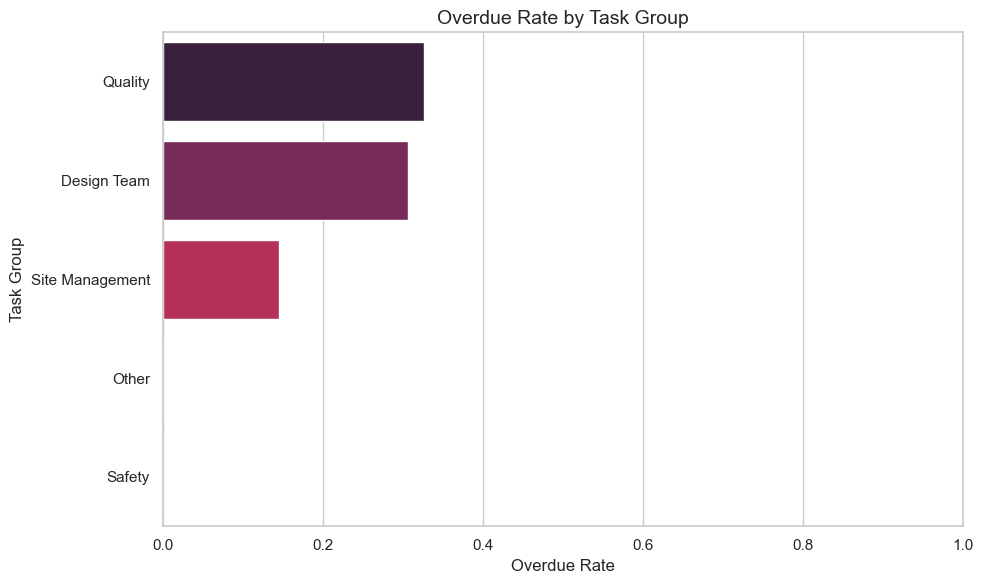

In [24]:
overdue=task.groupby("task_group")["overdue"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=overdue.values, y=overdue.index,palette="rocket")

plt.title("Overdue Rate by Task Group", fontsize=14)
plt.xlabel("Overdue Rate", fontsize=12)
plt.ylabel("Task Group", fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

This says overall the Quality group has showed higher rate in overdue followed by the design team.

Quality group has the highest overdue rate, meaning tasks classified under “Quality” are often delayed.

# Which Teams Are Involved in Overdue Tasks?

Let's take a closer look at which team has showed more overdue.

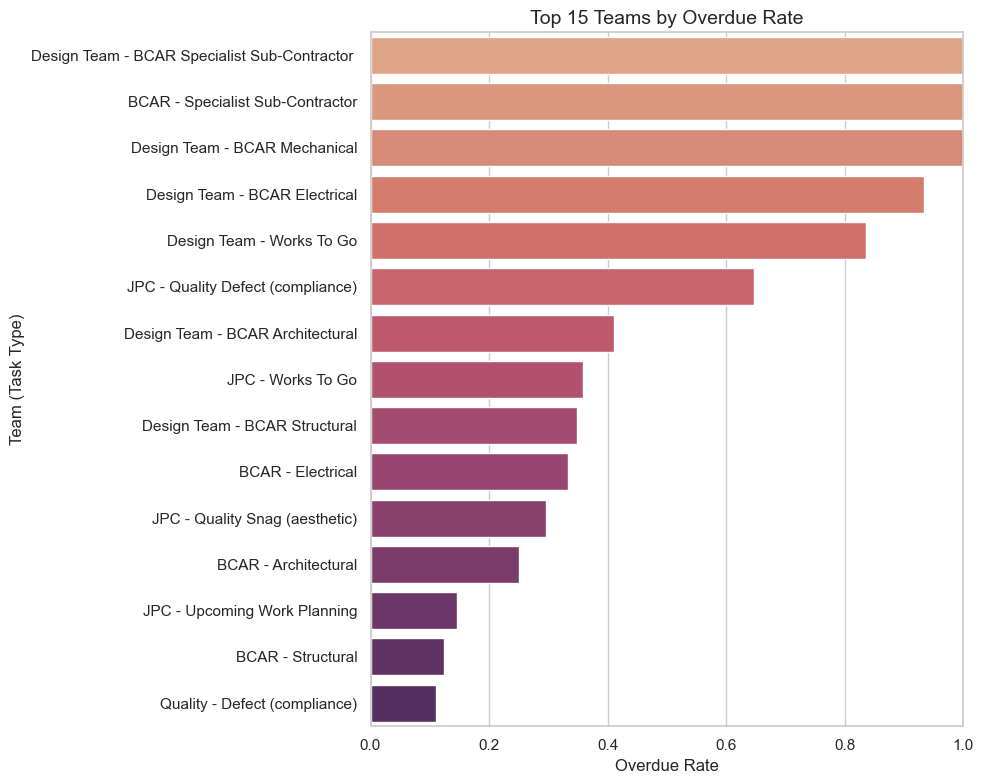

In [25]:
overdue_type=task.groupby("type")["overdue"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=overdue_type.values[:15],y=overdue_type.index[:15],palette="flare")

plt.title("Top 15 Teams by Overdue Rate", fontsize=14)
plt.xlabel("Overdue Rate")
plt.ylabel("Team (Task Type)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Quick Analysis: Where Are Tasks Overdue and Who's Responsible?

### Graph 1: Overdue Rate by Task Group
- **Quality** has the highest overdue rate, followed by the **Design Team**.
- **Safety** and **Site Management** have very few delays.

### Graph 2: Overdue Rate by Task Type
- Most top overdue task types belong to the **Design Team**, especially BCAR-related work.

### Why the Difference?
- **Task group** shows overall delay percentage, even for smaller groups.
- **Task type** shows which teams are repeatedly delayed.

So Design team show higher volume of late tasks while the quality team show higher percentage of the work done late

##  Question 3: When Are Delays Peaking?

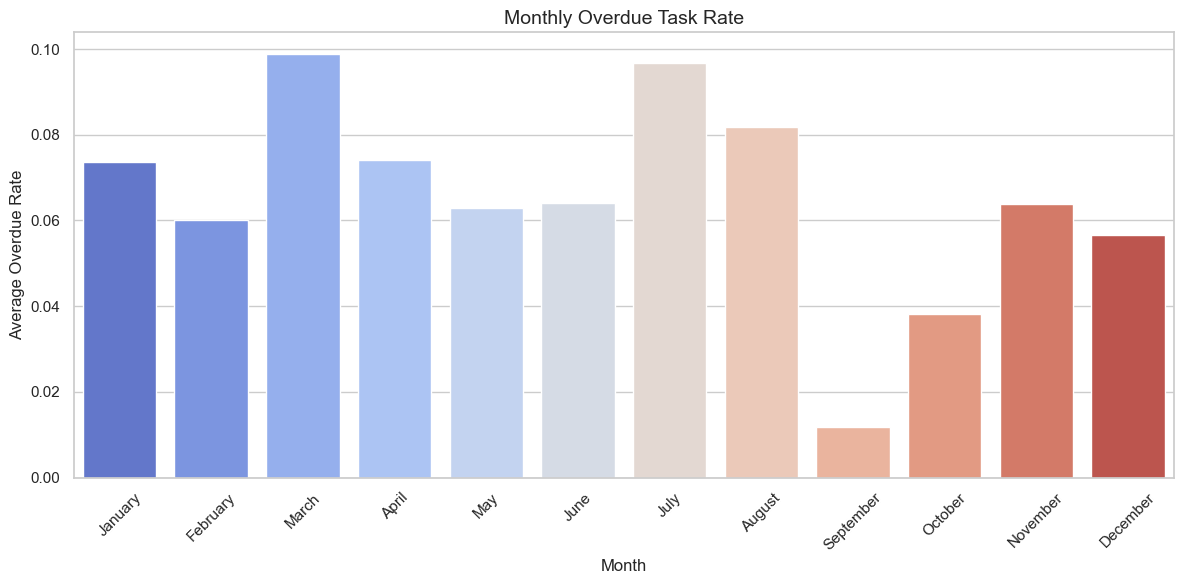

In [26]:
task["created"] = pd.to_datetime(task["created"], errors="coerce")

task["month"] = task["created"].dt.month_name()

month_order = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]

monthly_overdue = task.groupby("month")["overdue"].mean().reindex(month_order)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_overdue.index, y=monthly_overdue.values, palette="coolwarm")
plt.title("Monthly Overdue Task Rate", fontsize=14)
plt.ylabel("Average Overdue Rate")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


####  Key Observations:
- **Highest delays** occurred in **March, July, and August**.
- **September and October** had the **lowest overdue rates**.


### Possible Reasons:
- **Summer delays** (July–August) might be due to:
  - Team members on vacation
  - Project complexity increasing mid-year
- **Fall recovery** (September–October) might show teams catching up or fewer new tasks.

<Figure size 1200x600 with 0 Axes>

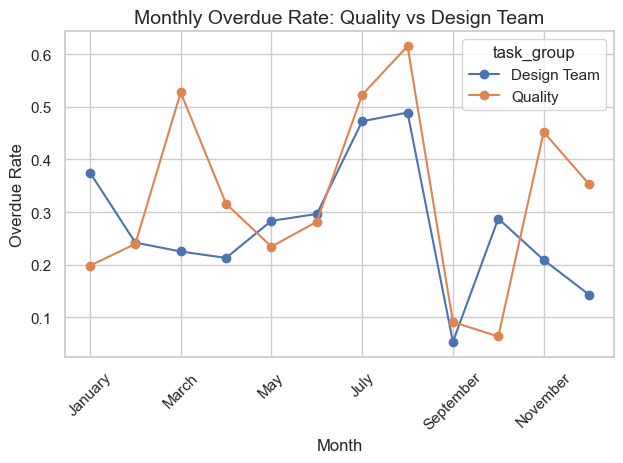

In [27]:
teams=task[task["task_group"].isin(["Quality", "Design Team"])]

monthly_overdue =teams.groupby(["month", "task_group"])["overdue"].mean().unstack()

monthly_overdue = monthly_overdue.reindex(month_order)

plt.figure(figsize=(12, 6))
monthly_overdue.plot(marker='o')
plt.title("Monthly Overdue Rate: Quality vs Design Team", fontsize=14)
plt.ylabel("Overdue Rate")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Here we see the trend of quality and design team delay over the year.
I see Quality team have a periodic trend of once in every 3 months they show overdue
While Design team has one peak in JUly and August



# Key Observations:

#### Quality Team
- Shows a **periodic spike** in delays approximately every 3 months.
- This suggests delays may be tied to **cyclical inspection or compliance schedules**, possibly aligned with the end of construction phases.
#### Design Team
- Has a **sharp spike in July and August**.
- This may be due to:
  - **Vacation-related staffing shortages**
  - Major **design submission deadlines**


# Modeling to find the actual cause of overdue

Lets do logistic regression modeling on both design and quality teams. Overdue is our traget variable lets see what are the other variables that cause it

In [34]:
task = tasks_clean.copy()

task["created"] = pd.to_datetime(task["created"], errors="coerce", dayfirst=True)
task["status_changed"] = pd.to_datetime(task["status_changed"], errors="coerce", dayfirst=True)
task["duration_days"] = (task["status_changed"] - task["created"]).dt.days

task = task.dropna(subset=["cause", "priority", "duration_days", "overdue", "task_group"])


design_df = task[task["task_group"] == "Design Team"].copy()
quality_df = task[task["task_group"] == "Quality"].copy()

In [35]:
design_df.shape

(1139, 22)

In [36]:
quality_df.shape

(931, 22)

### Design team data modeling
### Logistic Regression

In [53]:
X = design_df[["priority", "cause", "duration_days"]]#input
y = design_df["overdue"].astype(int)#target

In [54]:
#split for training and test 20% test 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
#change the priority and cause column into numbers
encoder = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), ["priority", "cause"])],
    remainder="passthrough"
)

In [56]:
#fitting logistic regression model
model = Pipeline([
    ("encoder", encoder),
    ("log_reg", LogisticRegression(max_iter=1000))
])

In [57]:
model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['priority', 'cause'])])),
                ('log_reg', LogisticRegression(max_iter=1000))])

In [58]:
y_pred = model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       160
           1       0.66      0.28      0.39        68

    accuracy                           0.74       228
   macro avg       0.70      0.61      0.61       228
weighted avg       0.72      0.74      0.70       228



In [60]:
# Overall Accuracy: 74%. That means the model gets 3 out of 4 tasks right.But it’s only catching 28% of actual overdue tasks (class 1).

### Random forest:

In [61]:
model = Pipeline([
    ("encoder", encoder),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [62]:
model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['priority', 'cause'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [63]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       160
           1       0.79      0.50      0.61        68

    accuracy                           0.81       228
   macro avg       0.80      0.72      0.74       228
weighted avg       0.81      0.81      0.80       228



In [69]:
print("Number of features:", len(model.named_steps["rf"].feature_importances_))

Number of features: 16


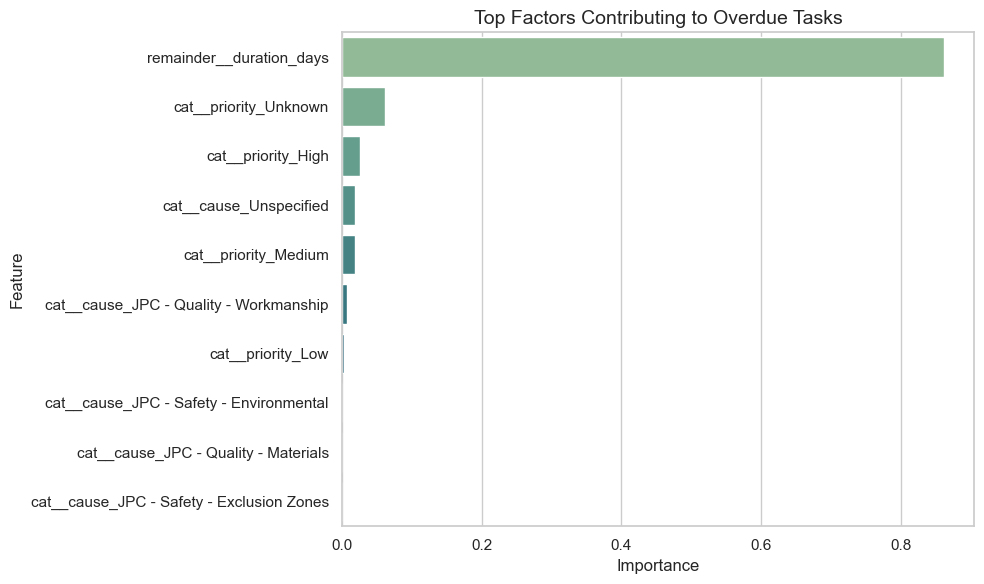

In [70]:
# Get all encoded feature names
encoded_feature_names = list(model.named_steps["encoder"].get_feature_names_out())

# Check if duration_days was passed through
if len(encoded_feature_names) < len(model.named_steps["rf"].feature_importances_):
    encoded_feature_names.append("duration_days")
    
feature_names = encoded_feature_names

importances = model.named_steps["rf"].feature_importances_

#DataFrame
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature", palette="crest")
plt.title("Top Factors Contributing to Overdue Tasks", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Reason for the Overdue (Design Team)

Overdue tasks by the **Design Team** mostly happen when:

- The task takes **a long time to complete** (especially around **July–August**, likely due to summer vacations).
- The **priority is unknown** or the **cause is unspecified**.

This means that **delays happen when tasks are both slow and poorly documented**.


**Top Risk = Long duration + unclear priority or cause**


### Quality team data Modeling
### Random Forest

In [71]:
X_q = quality_df[["priority", "cause", "duration_days"]]
y_q = quality_df["overdue"].astype(int)

In [72]:
Xq_train, Xq_test, yq_train, yq_test = train_test_split(
    X_q, y_q, test_size=0.2, random_state=42, stratify=y_q
)

In [73]:
encoder_q = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), ["priority", "cause"])],
    remainder="passthrough"
)

In [74]:
model_q = Pipeline([
    ("encoder", encoder_q),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [75]:
model_q.fit(Xq_train, yq_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['priority', 'cause'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [76]:
yq_pred = model_q.predict(Xq_test)
print(classification_report(yq_test, yq_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       126
           1       0.75      0.90      0.82        61

    accuracy                           0.87       187
   macro avg       0.85      0.88      0.86       187
weighted avg       0.88      0.87      0.87       187



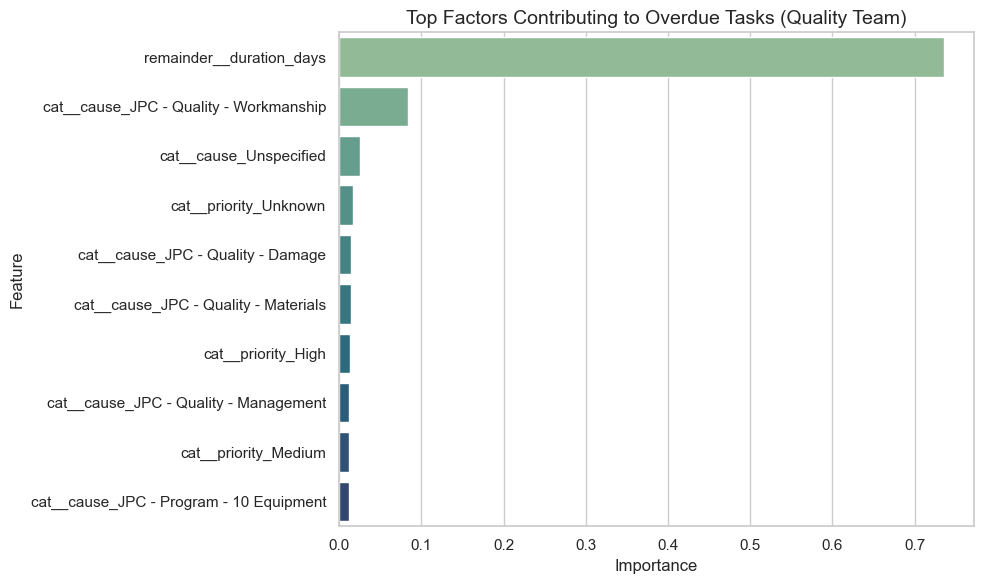

In [77]:
encoded_feature_names_q = list(model_q.named_steps["encoder"].get_feature_names_out())
if len(encoded_feature_names_q) < len(model_q.named_steps["rf"].feature_importances_):
    encoded_feature_names_q.append("duration_days")

importances_q = model_q.named_steps["rf"].feature_importances_

feat_imp_q = pd.DataFrame({
    "feature": encoded_feature_names_q,
    "importance": importances_q
}).sort_values(by="importance", ascending=False)

# Step 8: Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_q.head(10), x="importance", y="feature", palette="crest")
plt.title("Top Factors Contributing to Overdue Tasks (Quality Team)", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Reason for the Overdue (Quality Team)

Overdue tasks by the **Quality Team** mostly happen when:

- The task takes a **long time to complete**.
- The cause is related to **Workmanship issues**.
- Many tasks have **unspecified causes** or **unknown priority**.

This suggests that delays often come from **recurring quality issues**

**Top Risk = Workmanship problems + long durations + unclear documentation**


## Conclusion

Through this project, I demonstrated how data analytics can provide real value in construction project management by identifying delay patterns and their root causes.

- I applied ETL techniques to clean and prepare real-world project task data.
- I used visual analytics to explore trends by team, time, and task type.
- I built classification models (Logistic Regression and Random Forest) to understand what factors lead to overdue tasks.

### Key Takeaways:

- **Design Team delays** are driven by long durations and unclear task metadata (e.g., unknown priority).
- **Quality Team delays** often stem from recurring workmanship issues and vague documentation.
- **Seasonal peaks** in delays (July–August and March) point to staffing or scheduling gaps.

### Final Insight:
Improving documentation (priority, cause), monitoring team-specific delay patterns, and planning proactively around seasonal workload shifts can significantly reduce overdue tasks.